In [2]:
### Essentials
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.colors
import matplotlib.patches as mpatches
%matplotlib widget
from datetime import timedelta

#Oceanography tools
import gsw # https://teos-10.github.io/GSW-Python/gsw_flat.html
from iapws import iapws95
from physoce import tseries as ts 

#Scipy
from scipy.signal import welch 
from scipy.stats import chi2 
from scipy.special import gamma
from scipy import stats
from scipy import signal
from scipy.signal import periodogram
from scipy.signal import argrelextrema
from scipy.optimize import curve_fit
from scipy import integrate
from scipy.stats.distributions import  t

#Custom function packages
import sentinnel_tools as st
import vector_tools as vt

# IMPORT, FLAG, AND CLEAN DATA

In [2]:
# Take RDI textfile and convert to xarray dataset
adcp1 = st.WinADCP_to_dataset('ADCP/ADCP01_all.txt', depthOffset = 0.44)
adcp2 = st.WinADCP_to_dataset('ADCP/ADCP02_all.txt', depthOffset = 0.44)

# Conduct quality assurance tests and flag data
adcp1 = st.adcp_qc(adcp1)
adcp2 = st.adcp_qc(adcp2)

#Add extra metadata to the datasets
adcp1.attrs['Description'] = 'First deployment of ADCP in Stillwater Cove'
adcp1.attrs['Latitude'] = 36.56194210195769
adcp1.attrs['Longitude'] = -121.94175918358738
adcp1.attrs['Creator'] = 'Logan Grady'
adcp1.attrs['Contact information'] = 'logan.grady@sjsu.edu'

adcp2.attrs['Description'] = 'Second deployment of ADCP in Stillwater Cove'
adcp2.attrs['Latitude'] = 36.56194989498659
adcp2.attrs['Longitude'] = -121.9417662787946
adcp2.attrs['Creator'] = 'Logan Grady'
adcp2.attrs['Contact information'] = 'logan.grady@sjsu.edu'

Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Opening file and extracting data...
 
Generating xarray dataset...
 
Conversion complete!
Cannot conduct BIT test because variable does not exist in dataset


In [3]:
#Make sure all data and metadata looks good before exporting
adcp2

<xarray.Dataset>
Dimensions:         (time: 210000, bindist: 47)
Coordinates:
  * bindist         (bindist) float64 1.25 1.5 1.75 2.0 ... 12.25 12.5 12.75
  * time            (time) datetime64[ns] 2022-08-23T09:40:00 ... 2022-08-30T...
Data variables: (12/22)
    Pitch           (time) float64 -4.19 -4.18 -4.18 ... -26.51 -26.51 -26.51
    Roll            (time) float64 -0.1 -0.1 -0.09 -0.09 ... 25.22 25.21 25.21
    Heading         (time) float64 50.34 48.82 48.49 48.41 ... 29.43 29.27 29.2
    Temperature     (time) float64 20.18 20.13 20.15 20.19 ... 27.09 27.02 27.08
    Depth           (time) float64 0.44 0.44 0.44 0.44 ... 0.44 0.44 0.44 0.445
    Battery         (time) int64 0 181 181 181 181 181 ... 157 157 157 157 157
    ...              ...
    EA2             (bindist, time) int64 78 117 96 86 54 65 ... 46 47 46 45 47
    EA3             (bindist, time) int64 114 127 120 111 113 ... 46 45 45 44 45
    EA4             (bindist, time) int64 65 113 102 79 55 65 ... 44 45 45 46 48
    EA5             (bindist, time) float64 87.25 115.0 103.0 ... 44.25 46.25
    BIT             (time) int64 0 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0 0
    Flag            (bindist, time) float64 4.0 4.0 4.0 4.0 ... 4.0 4.0 4.0 4.0
Attributes: (12/15)
    PingsPerEns:          1
    TimePerPing:          00:01.00
    First Ensemble Date:  22/08/23
    First Ensemble Time:  09:40:00.00
    Ensemble Interval:    2.99
    Instrument Height:    0.44
    ...                   ...
    Instrument:           Broadband 1228.8 kHz
    Description:          Second deployment of ADCP in Stillwater Cove
    Latitude:             36.56194989498659
    Longitude:            -121.9417662787946
    Creator:              Logan Grady
    Contact information:  logan.grady@sjsu.edu

In [4]:
# Export the organized but raw data
adcp1.to_netcdf('ADCP/adcp1_raw.nc')
adcp2.to_netcdf('ADCP/adcp2_raw.nc')

In [3]:
#Import raw datafiles
adcp1_raw = xr.open_dataset('ADCP/adcp1_raw.nc')
adcp2_raw = xr.open_dataset('ADCP/adcp2_raw.nc')

In [5]:
#Trim data collected during deployment and recovery of the instrument
adcp1_qc = adcp1_raw.sel(time = slice('2022-07-22T00:00:00.000000000','2022-08-11T00:00:00.000000000')) #Keeps data within time slice

#Cut all profiles with mean flag values of 4, which are complete profile failures
adcp1_qc = adcp1_qc.where(adcp1_qc.Flag.mean(dim = "bindist") != 4).dropna(dim = 'time', how = 'all')

#Now for deployment two
adcp2_qc = adcp2_raw.sel(time = slice('2022-08-23T11:39:00.000000000','2022-08-30T11:39:00.000000000')) #Keeps data within time slice
adcp2_qc = adcp2_qc.where(adcp2_qc.Flag.mean(dim = "bindist") != 4).dropna(dim = 'time', how = 'all')

In [6]:
#Remove the data above the sea surface
adcp1_qc = st.adcp_seaSurface_removal(adcp1_qc)
adcp2_qc = st.adcp_seaSurface_removal(adcp2_qc)

#Nan out profiles with extremely high echo amplitude throughout water column
adcp1_qc = adcp1_qc.where(adcp1_qc.EA5.mean(dim = 'bindist') < 139)
adcp2_qc = adcp2_qc.where(adcp2_qc.EA5.mean(dim = 'bindist') < 139)

(array([19196., 19198., 19200., 19202., 19204., 19205., 19207., 19209.,
        19211., 19213., 19215.]),
 [Text(19196.0, 0, '2022-07-23'),
  Text(19198.0, 0, '2022-07-25'),
  Text(19200.0, 0, '2022-07-27'),
  Text(19202.0, 0, '2022-07-29'),
  Text(19204.0, 0, '2022-07-31'),
  Text(19205.0, 0, '2022-08-01'),
  Text(19207.0, 0, '2022-08-03'),
  Text(19209.0, 0, '2022-08-05'),
  Text(19211.0, 0, '2022-08-07'),
  Text(19213.0, 0, '2022-08-09'),
  Text(19215.0, 0, '2022-08-11')])

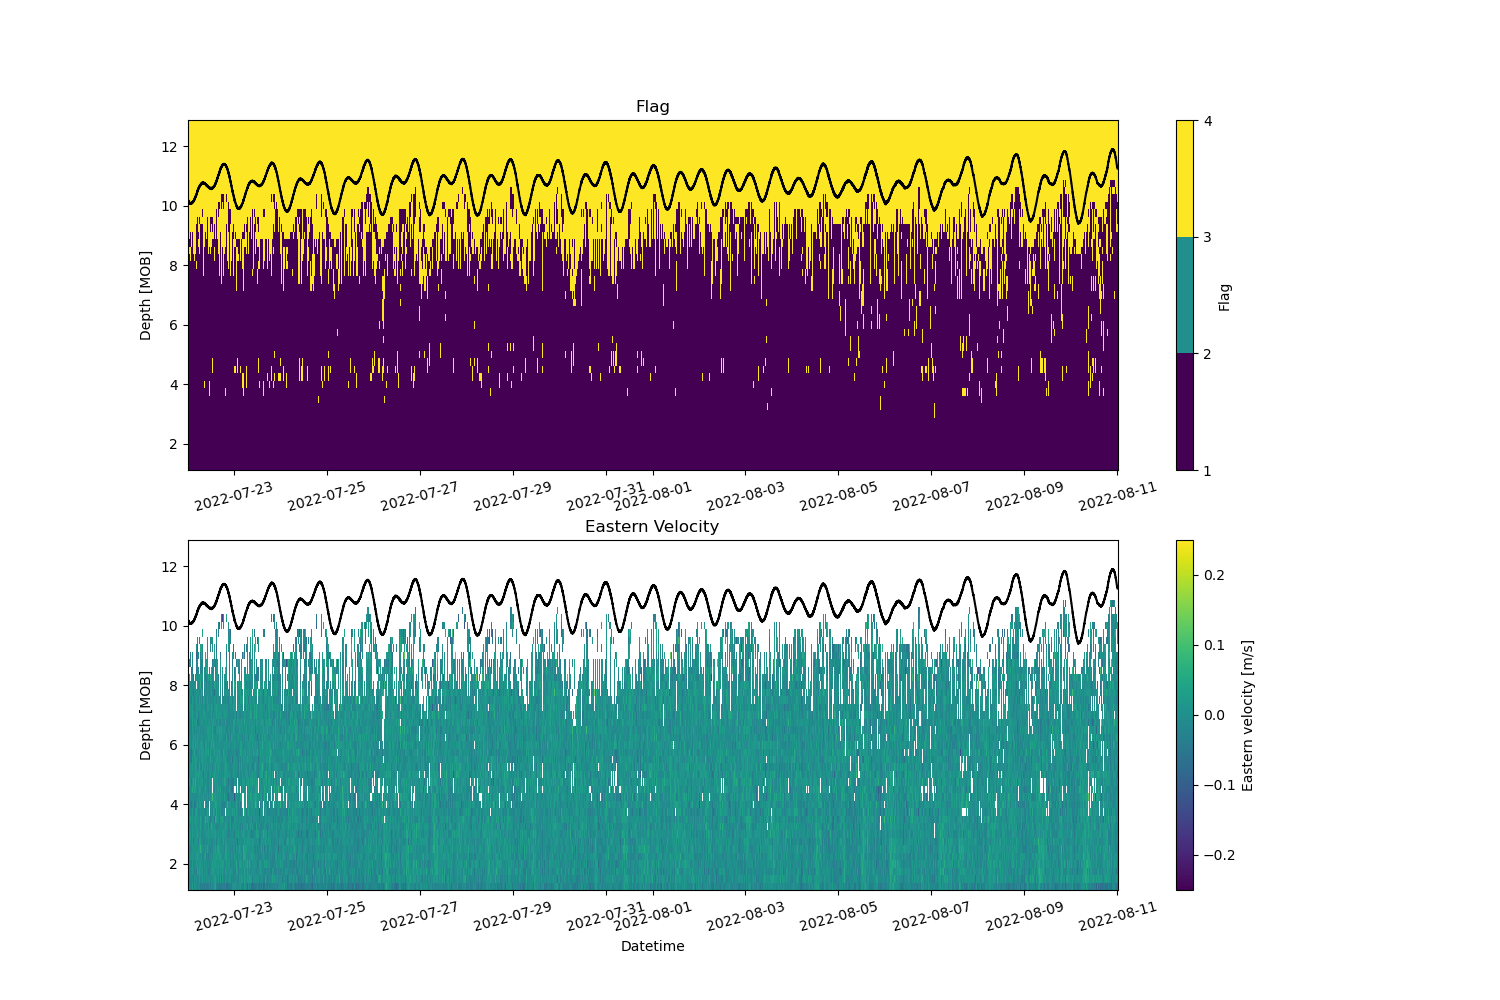

In [7]:
#Monitor full vector profile colorplots to check that remaining data is good quality
ds = adcp1_qc.copy(deep=True)

plt.figure(figsize = (15,10))

plt.subplot(211)
bounds = np.array([1, 2, 3, 4])
norm = matplotlib.colors.BoundaryNorm(boundaries=bounds, ncolors=256)
plt.title('Flag')
plt.pcolormesh(ds.time, ds.bindist, ds.Flag.values,norm=norm)
plt.plot(ds.time, ds.Depth, '-k')
plt.colorbar(label='Flag')
#plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xticks(rotation= 15)

plt.subplot(212)
plt.title('Eastern Velocity')
plt.pcolormesh(ds.time, ds.bindist, ds.East.where(ds.Flag <= 4),vmin=-.25, vmax = .25)
plt.plot(ds.time, ds.Depth, '-k')
plt.colorbar(label='Eastern velocity [m/s]')
#plt.ylim(1.25,12)
plt.ylabel('Depth [MOB]')
plt.xlabel('Datetime')
plt.xticks(rotation= 15)

In [30]:
adcp2_qc

<xarray.Dataset>
Dimensions:         (time: 201597, bindist: 47)
Coordinates:
  * bindist         (bindist) float64 1.25 1.5 1.75 2.0 ... 12.25 12.5 12.75
  * time            (time) datetime64[ns] 2022-08-23T11:40:00.100000 ... 2022...
Data variables: (12/22)
    Pitch           (time) float64 nan nan nan nan ... -0.56 -0.58 -0.56 -0.66
    Roll            (time) float64 nan nan nan nan nan ... -1.08 -1.1 -1.12 -1.2
    Heading         (time) float64 nan nan nan nan ... 277.8 277.9 277.9 277.6
    Temperature     (time) float64 nan nan nan nan ... 12.72 12.79 12.77 12.79
    Depth           (time) float64 nan nan nan nan ... 10.9 10.91 10.93 10.97
    Battery         (time) float64 nan nan nan nan ... 154.0 154.0 154.0 154.0
    ...              ...
    EA2             (bindist, time) float64 nan nan nan ... 124.0 119.0 119.0
    EA3             (bindist, time) float64 nan nan nan nan ... 94.0 96.0 92.0
    EA4             (bindist, time) float64 nan nan nan ... 140.0 131.0 130.0
    EA5             (bindist, time) float64 nan nan nan ... 123.0 116.5 113.2
    BIT             (time) float64 nan nan nan nan nan ... 0.0 0.0 0.0 0.0 0.0
    Flag            (bindist, time) float64 nan nan nan nan ... 4.0 4.0 4.0 4.0
Attributes: (12/15)
    PingsPerEns:          1
    TimePerPing:          00:01.00
    First Ensemble Date:  22/08/23
    First Ensemble Time:  09:40:00.00
    Ensemble Interval:    2.99
    Instrument Height:    0.44
    ...                   ...
    Instrument:           Broadband 1228.8 kHz
    Description:          Second deployment of ADCP in Stillwater Cove
    Latitude:             36.56194989498659
    Longitude:            -121.9417662787946
    Creator:              Logan Grady
    Contact information:  logan.grady@sjsu.edu

### Rotate vectors along principle axes

In [9]:
#Create depth averaged velocities for ENU vectors
adcp1_qc['EastDA'] = adcp1_qc.East.mean(dim = "bindist")
adcp1_qc['NorthDA'] = adcp1_qc.North.mean(dim = "bindist")
adcp1_qc['VerticalDA'] = adcp1_qc.Vertical.mean(dim = "bindist")

adcp2_qc['EastDA'] = adcp2_qc.East.mean(dim = "bindist")
adcp2_qc['NorthDA'] = adcp2_qc.North.mean(dim = "bindist")
adcp2_qc['VerticalDA'] = adcp2_qc.Vertical.mean(dim = "bindist")

#Find angle to rotate coordinate plane along primary and secondary principle axes
theta1, major1, minor1 = ts.princax(adcp1_qc.EastDA, adcp1_qc.NorthDA) # theta = angle, major = SD major axis (U), SD minor axis (V)
U1, V1 = ts.rot(adcp1_qc.EastDA, adcp1_qc.NorthDA, -theta1-90) #-theta - 90 rotates ensures the coordinate plane is rotated
                                                               #and not the vectors themselves

theta2, major2, minor2 = ts.princax(adcp2_qc.EastDA, adcp2_qc.NorthDA)
U2, V2 = ts.rot(adcp2_qc.EastDA, adcp2_qc.NorthDA, -theta2-90)

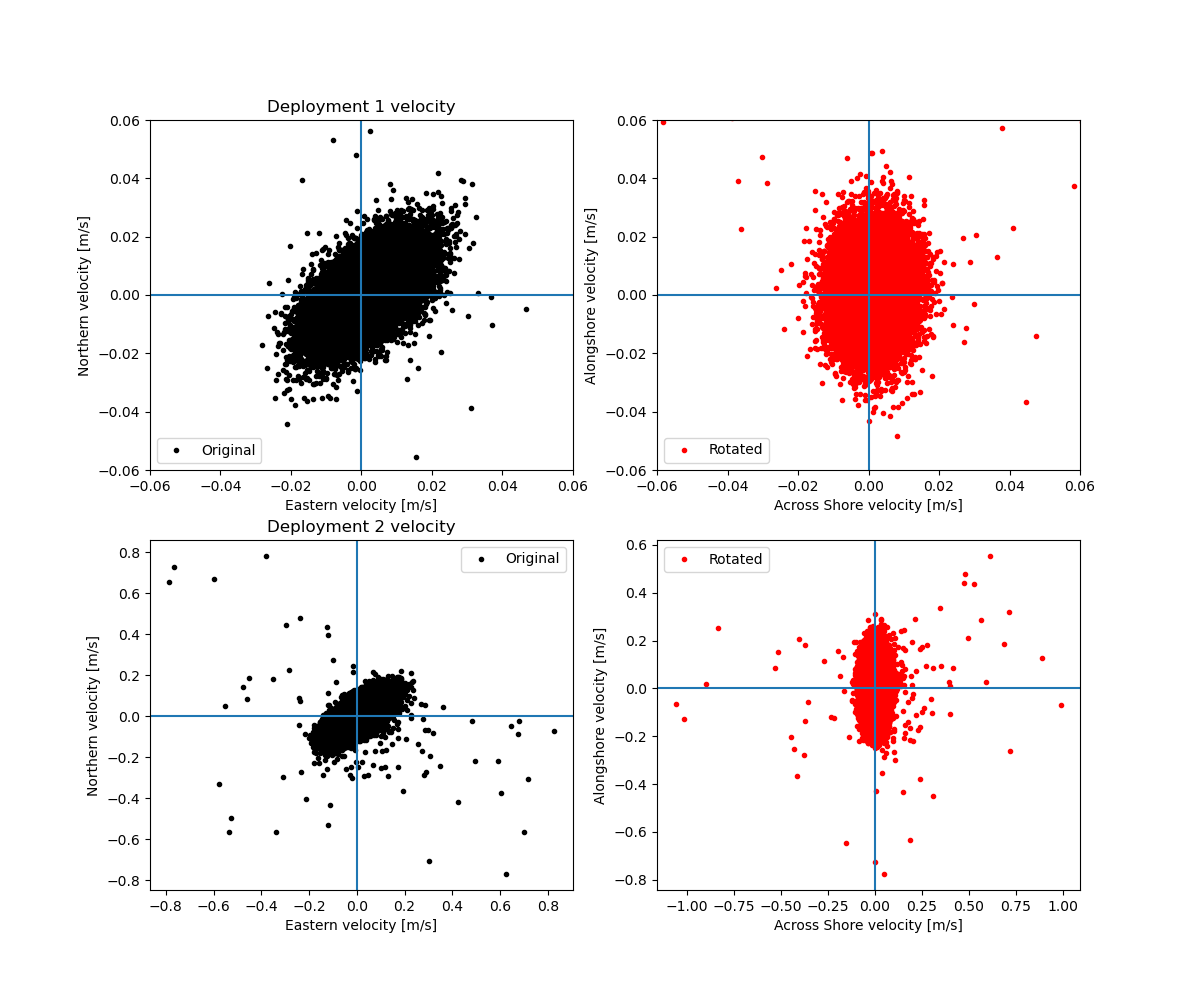

In [10]:
#Look at original vs. rotated vectors to visualize the priciple axes
plt.figure(figsize=(12,10))

plt.subplot(221)
plt.plot(adcp1_qc.EastDA, adcp1_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 1 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
plt.xlim(-.06, .06)
plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(222)
plt.plot(-U1, -V1, '.r', label = 'Rotated')
plt.xlabel('Across Shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
plt.xlim(-.06, .06)
plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(223)
plt.plot(adcp2_qc.EastDA, adcp2_qc.NorthDA, '.k', label = 'Original')
plt.title('Deployment 2 velocity')
plt.xlabel('Eastern velocity [m/s]')
plt.ylabel('Northern velocity [m/s]')
#plt.xlim(-.06, .06)
#plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

plt.subplot(224)
plt.plot(-U2, -V2, '.r', label = 'Rotated')
plt.xlabel('Across Shore velocity [m/s]')
plt.ylabel('Alongshore velocity [m/s]')
#plt.xlim(-.06, .06)
#plt.ylim(-.06, .06)
plt.axhline(y=0)
plt.axvline(x=0)
plt.legend()

Given the shape of coastline where mooring is located:
- Northeast/Southwest velocities have highest variance and correspond to alongshore direction of Arrowhead Point
- Northwest/Southeast velocity correspond more to acrossshore
- Positive alongshore indicates onshore current into SWC
- Positive across shore means onshore current towards Arrowhead Point

In [20]:
#Create rotated vector variables as alongshore and across shore
adcp1_qc['PrimaryDA'] = (["time"], -V1)                 #Signs are flipped for velocities to correct the velocities
adcp1_qc['PrimaryDA'].attrs['Direction'] = 'Alongshore' #into proper onshore (positive) and offshore (negative) values
adcp1_qc['PrimaryDA'].attrs['Standard deviation'] = major1
adcp1_qc['SecondaryDA'] = (["time"], -U1) 
adcp1_qc['SecondaryDA'].attrs['Direction'] = 'Across-shore'
adcp1_qc['SecondaryDA'].attrs['Standard deviation'] = minor1

adcp2_qc['PrimaryDA'] = (["time"], -V2) 
adcp2_qc['PrimaryDA'].attrs['Direction'] = 'Alongshore'
adcp2_qc['PrimaryDA'].attrs['Standard deviation'] = major2
adcp2_qc['SecondaryDA'] = (["time"], -U2) 
adcp2_qc['SecondaryDA'].attrs['Direction'] = 'Across-shore'
adcp2_qc['SecondaryDA'].attrs['Standard deviation'] = minor2

#Add the rotation angle to the attributes of the original adcp datasets
adcp1_qc.attrs['Principle Axes rotation angle'] = -theta1-90
adcp2_qc.attrs['Principle Axes rotation angle'] = -theta2-90

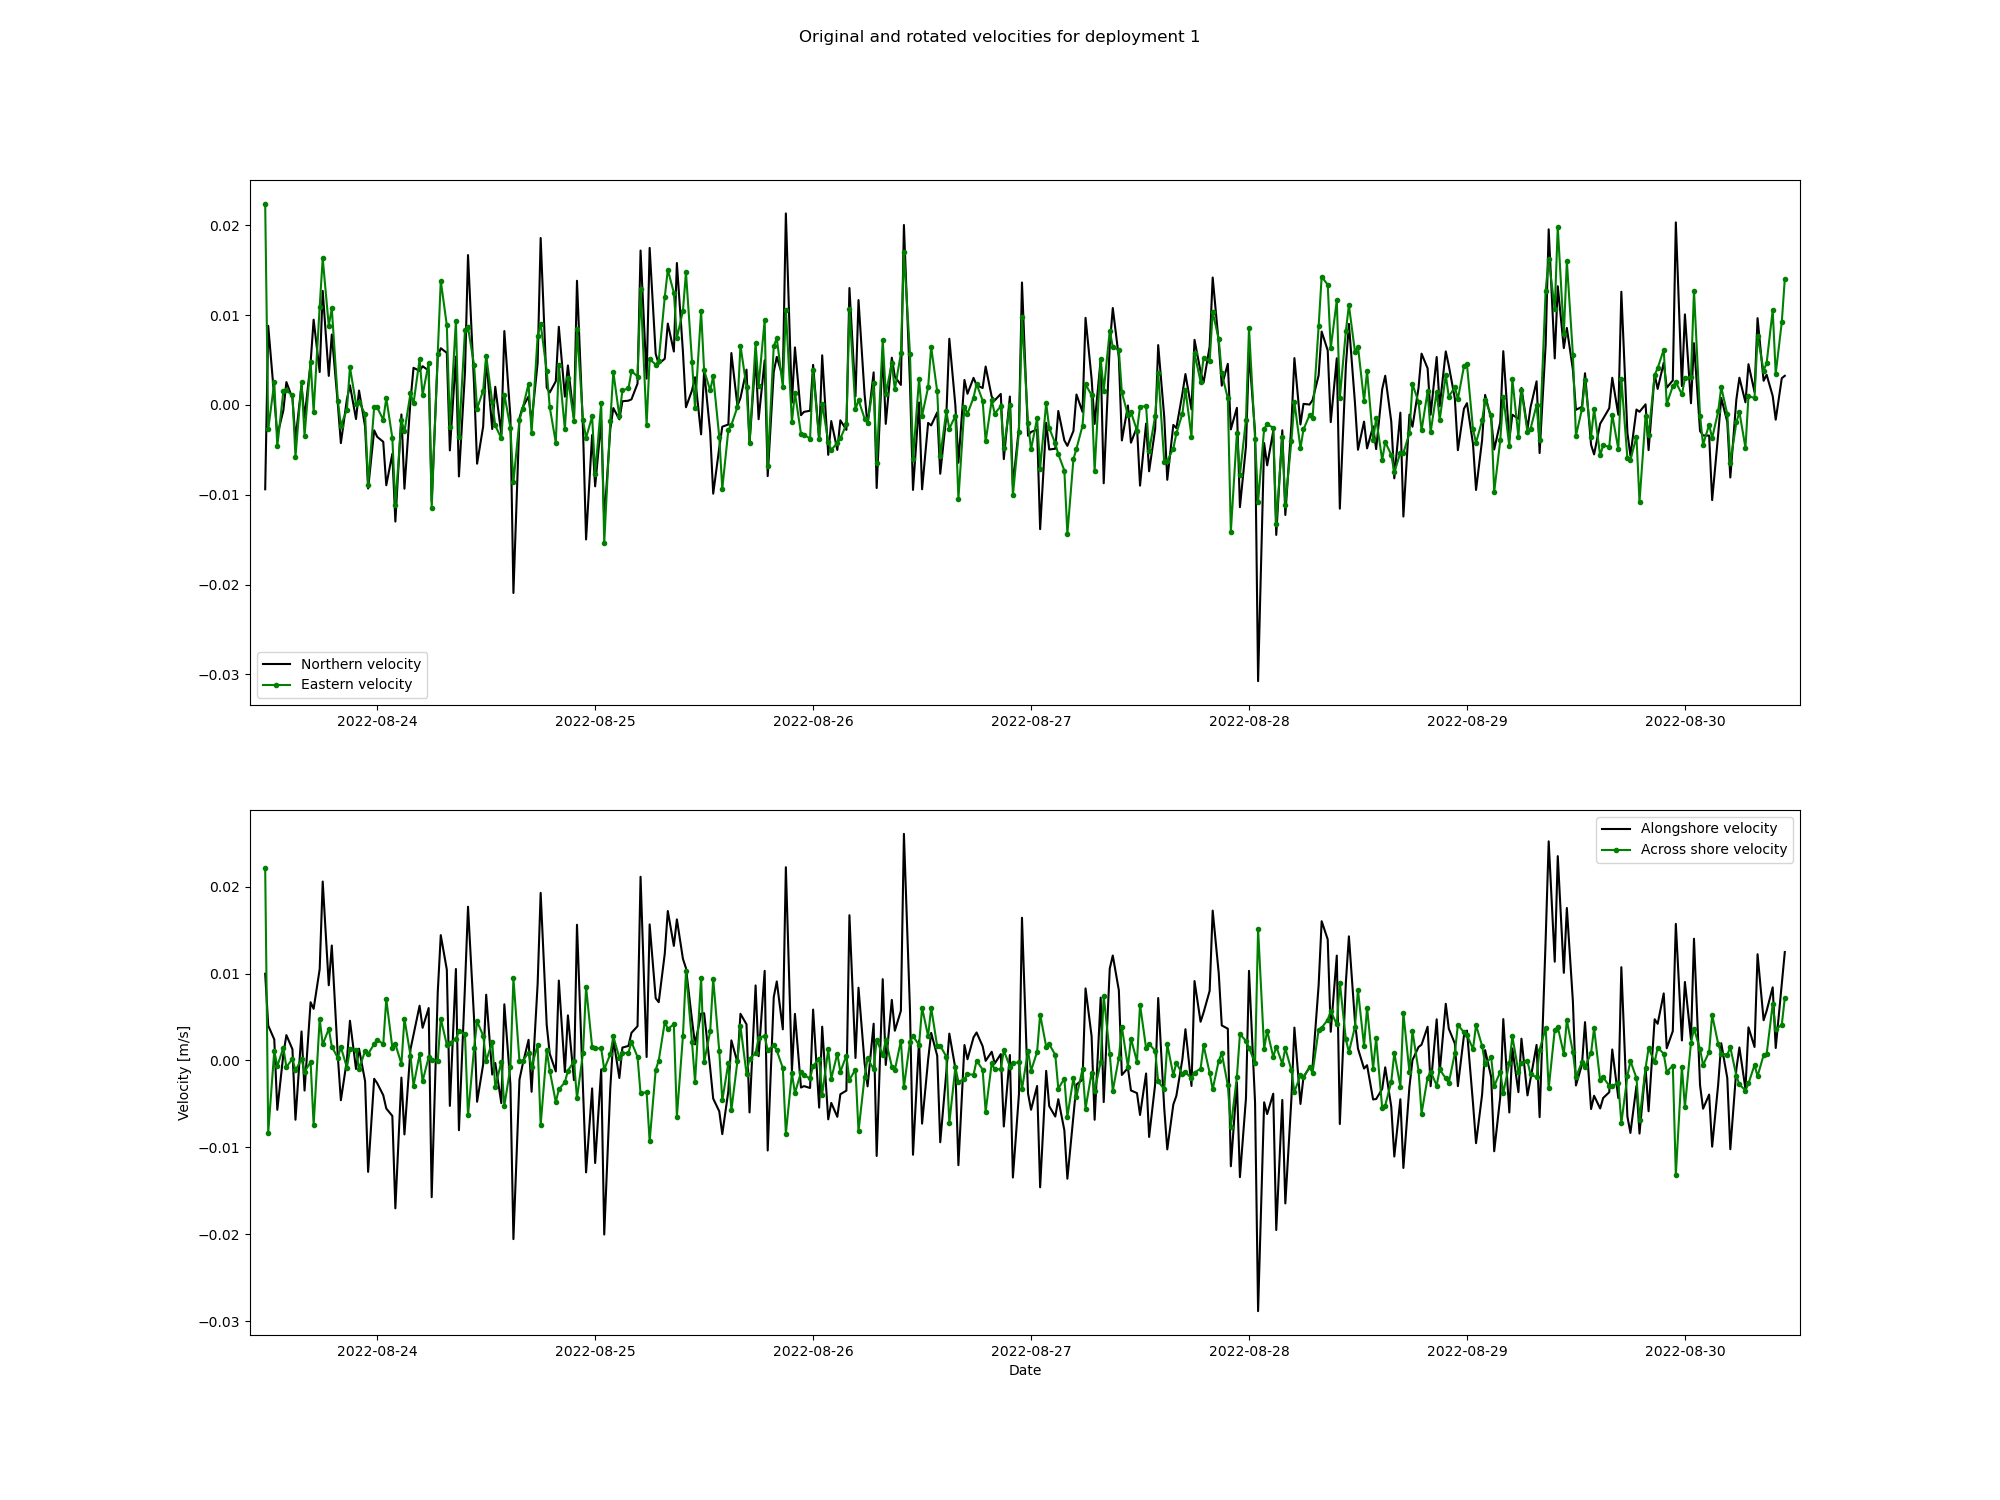

In [24]:
ds = adcp2_qc.copy(deep=True)

North = ds.NorthDA.resample(time='20Min').mean().dropna(dim='time')
East = ds.EastDA.resample(time='20Min').mean().dropna(dim='time')
Alongshore = ds.PrimaryDA.resample(time='20Min').mean().dropna(dim='time')
AcrossShore = ds.SecondaryDA.resample(time='20Min').mean().dropna(dim='time')

plt.figure(figsize=(20,15))
plt.suptitle('Original and rotated velocities for deployment 1')

plt.subplot(211)
plt.plot(North.time, North, '-k', label = 'Northern velocity')
plt.plot(East.time, East, '.-g', label = 'Eastern velocity')
plt.margins(x=.01)
plt.legend()

plt.subplot(212)
plt.plot(Alongshore.time, Alongshore, '-k', label = 'Alongshore velocity')
plt.plot(AcrossShore.time, AcrossShore, '.-g', label = 'Across shore velocity')
plt.ylabel('Velocity [m/s]')
plt.ylabel('Velocity [m/s]')
plt.xlabel('Date')
plt.margins(x=.01)
plt.legend()

In [25]:
#Export clean data to netcdf
adcp1_qc.to_netcdf('ADCP/adcp1_final.nc')
adcp2_qc.to_netcdf('ADCP/adcp2_final.nc')

In [3]:
#Import clean data
adcp1_qc = xr.open_dataset('ADCP/adcp1_final.nc')
adcp2_qc = xr.open_dataset('ADCP/adcp2_final.nc')

# BEAM COORDINATES
Have adcp velocities converted to beam coordinates for measuring reynolds stress from mode 12 data

In [ ]:
# Import the beam coordinate csv's
b1 = pd.read_csv('ADCP/SWC2_000_1_export.csv')
b2 = pd.read_csv('ADCP/SWC2_000_2_export.csv')
b3 = pd.read_csv('ADCP/SWC2_000_3_export.csv')
b4 = pd.read_csv('ADCP/SWC2_000_4_export.csv')

In [ ]:
# Combine the csv's in chronological order
#data = b1.append(b2)
#data = data.append(b3)
#data = data.append(b4)
#data = data.reset_index(drop=True)
#data = data.drop(columns=['index'])
#data.to_csv('ADCP/beam_data.csv', index=False)
data = pd.read_csv('ADCP/beam_data.csv')

In [ ]:
vel = data.filter(like='V')

In [ ]:
vel_B1 = vel.filter(like='B1')
vel_B2 = vel.filter(like='B2')
vel_B3 = vel.filter(like='B3')
vel_B4 = vel.filter(like='B4')

In [ ]:
time = pd.to_datetime(data.iloc[:,1])
dcell = range(1,48,1)

In [ ]:
B1_arr = vel_B1.to_numpy()
B2_arr = vel_B2.to_numpy()
B3_arr = vel_B3.to_numpy()
B4_arr = vel_B4.to_numpy()

In [ ]:
# create coords
rows = range(1,48,1) 
cols = time

# put data into a dataset
ds = xr.Dataset(
    data_vars=dict(
        B1=(["time", "dcell"], B1_arr),
        B2=(["time", "dcell"], B2_arr),
        B3=(["time", "dcell"], B3_arr),
        B4=(["time", "dcell"], B4_arr)
    ),
    coords=dict(
        dcell=(["dcell"], rows),
        time=(["time"], cols),
    ),
    attrs=dict(description="Velocity in beam coordinates"),
)

In [ ]:
ds['B1'].attrs['units'] = 'mm/s'
ds['B2'].attrs['units'] = 'mm/s'
ds['B3'].attrs['units'] = 'mm/s'
ds['B4'].attrs['units'] = 'mm/s'